# Notebook Purpose

Implement TCAV using Pytorch for CLIP

# Load Dependencies

In [1]:
#https://github.com/openai/CLIP
# authors Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings), nerdyrodent
# authors vivian
# The original BigGAN+CLIP method was by https://twitter.com/advadnoun
import threading
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math
import random
from urllib.request import urlopen
from tqdm import tqdm
import sys
import os
sys.path.append('taming-transformers')
from omegaconf import OmegaConf
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.cuda import get_device_properties
torch.backends.cudnn.benchmark = False
from torch_optimizer import DiffGrad, AdamP, RAdam
from CLIP import clip
import kornia.augmentation as K
import imageio
from PIL import ImageFile, Image, PngImagePlugin, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True
from subprocess import Popen, PIPE
import re
import pickle

In [2]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load CLIP

In [4]:
model, preprocess = clip.load('ViT-B/32', device)

In [5]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

In [6]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [7]:
# possibly needed in future if using larger dataset w/ dataloader

# embedding_list = np.empty(layers.shape, dtype=object)
# for i in range(len(embedding_list)):
#     embedding_list[i] = []
# for num_layer, name  in enumerate(layernames):
#     embedding_list[num_layer].append(activations[name])

# Image Encoding

# Text Encoding

In [8]:
def get_img_tensors(img_filename, img_dir=""):
    image = preprocess(Image.open(img_dir + img_filename)).unsqueeze(0).to(device)
    return image

In [9]:
def encode_images(img_filename, img_dir=""):
    image = preprocess(Image.open(img_dir + img_filename)).unsqueeze(0).to(device)

    image_features = model.encode_image(image.cuda())
    return image_features

Load an example image

# Define Linear Classifiers

In [10]:
class LinearClassifier(torch.nn.Module):
    
    def __init__(self, num_features):
        super().__init__()
        
        self.linear1 = torch.nn.Linear(num_features, 1)
        

    def forward(self, input_x):
        x = self.linear1(input_x)

        return x

In [11]:
positive_filenames = os.listdir('tcav/concepts/striped')
negative_filenames = os.listdir('tcav/concepts/random_0')

In [12]:
positive_concept = [encode_images(filename, 'tcav/concepts/striped/') for filename in positive_filenames]
#positive_concept = torch.vstack(positive_concept)

In [13]:
negative_concept = [encode_images(filename, 'tcav/concepts/random_0/') for filename in negative_filenames]
#negative_concept = torch.vstack(negative_concept)

In [14]:
# all_concept = positive_concept + negative_concept

In [15]:
positive_concepts = torch.vstack(positive_concept)
negative_concepts = torch.vstack(negative_concept)

In [16]:
positive_img_tensors = [get_img_tensors(img,'tcav/concepts/striped/') for img in positive_filenames]
positive_img_tensors = torch.vstack(positive_img_tensors)
negative_img_tensors = [get_img_tensors(img,'tcav/concepts/random_0/') for img in negative_filenames]
negative_img_tensors = torch.vstack(negative_img_tensors)

In [18]:
all_img_tensors = torch.vstack([positive_img_tensors, negative_img_tensors])

In [20]:
folder = '/home/valentinedhauteville/dataset/tcav/concepts/'
# image_classes = ['smeared','dotted', 'knitted', 'spiralled', 'chequered']
# image_classes = ['giraffe','light','vegetable','fish','book', 'baby', 'street']
image_classes = ['smeared','dotted', 'knitted', 'spiralled', 'chequered',
                 'giraffe','light','vegetable','fish','book', 'baby', 'street']
image_tensors = np.zeros((len(image_classes),2), dtype=object) # [{positive, negative}, image_class]
num_rand_folders = 5
for num_class, img_class in enumerate(image_classes):
    class_folder  = folder + img_class + '/'
    random_folder = folder + f'random_{num_class % num_rand_folders}/'
    pos_files = os.listdir(class_folder)
    neg_files = os.listdir(random_folder)[:len(pos_files)]
    image_tensors[num_class,0] = torch.vstack([get_img_tensors(img, class_folder) for img in pos_files]) # positive tensors
    image_tensors[num_class,1] = torch.vstack([get_img_tensors(img, random_folder) for img in neg_files]) # negative tensors


## Get image class embeddings

### Register hooks for activations

In [21]:
# assist from https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/
activations = {}
gradients = {}
def getActivation(name):
    # the hook signature 
    def hook(model, input, output):
        
        output.requires_grad_(True)
        output.retain_grad()
        gradients[name] = output.grad
        activations[name] = output.detach()
    return hook

In [22]:
hooks = []
layers = np.concatenate([[model.visual.conv1], model.visual.transformer.resblocks[1::2], [model.visual]])
layernames = np.concatenate([['layer0'], [f'layer{i}' for i in range(1,13,2)],['full']], dtype=str)
for l, n in zip(layers, layernames):
    hooks.append(l.register_forward_hook(getActivation(n)))

### Push images through model

In [23]:
# concept_embeddings = np.zeros((len(image_classes),2), dtype=object) # shape=[class, {positive, negative}]
per_layer_embeddings = np.zeros((len(image_classes), 2, len(layers)), dtype=object)

for pos_or_neg in [0,1]:
    for i in range(len(image_classes)):
#         concept_embeddings[i, pos_or_neg] = model.encode_image(image_tensors[i, pos_or_neg])
        model.encode_image(image_tensors[i, pos_or_neg]) # push through model

        # pull activations from each layer (incl. final layer with full visual)
        for layer, name in enumerate(layernames):
            per_layer_embeddings[i, pos_or_neg, layer] = activations[name]
            print(activations[name].shape)

torch.Size([120, 768, 7, 7])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([120, 512])
torch.Size([120, 768, 7, 7])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([120, 512])
torch.Size([120, 768, 7, 7])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([120, 512])
torch.Size([120, 768, 7, 7])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([120, 512])
torch.Size([120, 768, 7, 7])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.Size([50, 120, 768])
torch.S

In [24]:
# filename = f"{[f'{i}_' for i in image_classes]}_per_layer_embeddings.pkl"
# filename = "smeared_dotted_knitted_spiralled_chequered_per_layer_embeddings.pkl"
# filename = "'giraffe','light','vegetable','fish','book', 'baby', 'street'embeddings.pkl"
filename = "all_embeddings.pkl"

In [25]:
with open(filename,"wb") as f:
    pickle.dump(per_layer_embeddings,f)

### flatten embedding layers

In [79]:
flattened_data = np.zeros((len(image_classes), len(layers)), dtype=object)
for i in range(len(image_classes)):
    for layer in range(len(layers)):
        pos_size = image_tensors[i,0].shape[0]
        neg_size = image_tensors[i,1].shape[0]
        pos_flat = per_layer_embeddings[i,0,layer].reshape(pos_size, -1)
        neg_flat = per_layer_embeddings[i,1,layer].reshape(neg_size, -1)
        flattened_data[i,layer] = torch.cat([pos_flat, neg_flat])
#         training_data.append(all_layer_gradients[key][0].view(85,-1))
#         linear_classifier_sizes.append(all_layer_gradients[key][0].view(85,-1).shape[-1])
    

In [84]:
print(flattened_data.shape)
print(flattened_data[0,0].shape)

(12, 8)
torch.Size([16, 564480])


### Create target dataset

In [28]:
class_labels = np.zeros((len(image_classes)), dtype=object)
for i in range(len(image_classes)):
    positive_labels = torch.tensor(image_tensors[i,0].shape[0] * [1])
    negative_labels = torch.tensor(image_tensors[i,1].shape[0] * [0])
    class_labels[i] = torch.cat([positive_labels, negative_labels])

In [29]:
criterion = torch.nn.BCEWithLogitsLoss()
class_dataloaders = np.zeros((len(image_classes), len(layers), 3), dtype=object)
data = flattened_data # shape [num_classes, num_layers, [+ activations, - activations]]
for i in range(len(image_classes)):
    len_train = int(0.7 * data[i,0].shape[0])
    len_val   = int(0.125 * data[i,0].shape[0])
    len_test  = data[i,0].shape[0] - len_train - len_val

    for layer in range(len(layers)):
        dataset = TensorDataset(data[i,layer], class_labels[i])
        torch.manual_seed(0)
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [len_train, len_val, len_test])
        class_dataloaders[i,layer,0] = DataLoader(train_dataset, batch_size=2,
                                                  pin_memory=False, shuffle=True)
        class_dataloaders[i,layer,1] = DataLoader(val_dataset, batch_size=2,
                                                  pin_memory=False, shuffle=True)
        class_dataloaders[i,layer,2] = DataLoader(test_dataset, batch_size=2,
                                                  pin_memory=False, shuffle=True)

In [30]:
class_layer_sizes = np.zeros((len(image_classes), len(layers)),dtype=int)
for i in range(len(image_classes)):
    for l in range(len(layers)):
        class_layer_sizes[i,l] = int(data[i,l][0].shape[-1])

## make classifiers

In [31]:
classifiers = np.zeros((len(image_classes), len(layers)), dtype=object)
for i in range(len(image_classes)):
    for l in range(len(layers)):
        classifiers[i,l] = LinearClassifier(class_layer_sizes[i,l])

# TRAIN Classifiers

In [32]:
def train_classifier(classifier, dataloader, val_dataloader):
    clf = classifier.cuda()
    early_stopping = EarlyStopping(patience=3)
    optimizer = torch.optim.SGD(clf.parameters(), lr=0.001)
    for it in range(n_epochs):
        for i, data in enumerate(dataloader,0):
            inputs, labels = data
            inputs = Variable(inputs, requires_grad=True)
            optimizer.zero_grad()
            outputs = clf(inputs.cuda().float())

            loss = criterion(outputs.cuda().float(), labels.cuda().reshape(-1,1).float())
            loss.backward()
            
            
            optimizer.step()
        with torch.no_grad():
            for i, data in enumerate(val_dataloader,0):
                inputs, labels = data
                inputs = Variable(inputs)
                outputs = clf(inputs.cuda().float())

                loss = criterion(outputs.cuda().float(), labels.cuda().reshape(-1,1).float()) 
        
            early_stopping(loss)
        if it % 10 == 0:
            print(loss)
            pass
        if early_stopping.early_stop:
            print(loss)
            break

In [33]:
n_epochs = 1000
for i in range(len(image_classes)):
    for l in range(len(layers)):
        classifier = classifiers[i,l]
        dataloader = class_dataloaders[i,l,0]
        val_dataloader = class_dataloaders[i,l,1]
        
        print(f"training class: {image_classes[i]} layer: {l}")
        train_classifier(classifier, dataloader, val_dataloader)
        print("trained a classifier")

training class: smeared layer: 0
tensor(0.0332, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.0369, device='cuda:0')
trained a classifier
training class: smeared layer: 1
tensor(0.5662, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
tensor(0.1434, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.2215, device='cuda:0')
trained a classifier
training class: smeared layer: 2
tensor(0.4986, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.1893, device='cuda:0')
trained a classifier
training class: smeared layer: 3
tensor(0.5817, device='cuda:0')
INFO: Early stoppi

tensor(0.7130, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.7412, device='cuda:0')
tensor(0.7412, device='cuda:0')
trained a classifier
training class: spiralled layer: 2
tensor(0.5081, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
tensor(0.0843, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.4681, device='cuda:0')
trained a classifier
training class: spiralled layer: 3
tensor(0.3869, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
INFO: Earl

tensor(0.7597, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.6543, device='cuda:0')
trained a classifier
training class: light layer: 3
tensor(0.5523, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.5780, device='cuda:0')
trained a classifier
training class: light layer: 4
tensor(0.7070, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
tensor(0.3580, device='cuda:0')
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.4419, device='cuda:0')
trained a classifier
training class: light layer: 5
tensor(0.7282, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping 

INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.4878, device='cuda:0')
trained a classifier
training class: book layer: 4
tensor(0.5655, device='cuda:0')
INFO: Early stopping counter 1 of 3
tensor(0.2213, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 3 of 3
INFO: Early stopping
tensor(0.1498, device='cuda:0')
tensor(0.1498, device='cuda:0')
trained a classifier
training class: book layer: 5
tensor(0.2028, device='cuda:0')
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
INFO: Early stopping counter 2 of 3
INFO: Early stopping counter 1 of 3
tensor(0.0676, device='cuda:0')
INFO: Early stopping counter 2 of 3
INFO: Early stopping

In [34]:
# with open("classifiers_perclass_perlayer_smeared_dotted_knitted_spiralled_chequered.pkl","wb") as f:
#     pickle.dump(classifiers,f)
# f = "classifiers_perclass_perlayer_smeared_dotted_knitted_spiralled_chequered"
# f = "classifiers_perclass_perlayer_giraffe_light_vegetable_fish_book_baby_street"
f = "all_classifiers"
np.save(f, classifiers, allow_pickle=True)

In [36]:
classifiers = np.load(f"{f}.npy", allow_pickle=True)

In [37]:
classifiers.shape

(12, 8)

In [38]:
test_results=np.zeros((len(image_classes),len(layers)))
for i in range(len(image_classes)):
    print(image_classes[i])
    for l in range(len(layers)):
        clf = classifiers[i,l]
        inputs, labels = class_dataloaders[i,l,2].dataset[:]
        inputs = Variable(inputs)
        outputs = clf(inputs.cuda().float())
#         print(len(inputs),len(outputs),len(labels))
#         print(binary_acc(inputs))
        num_correct = 0
#         print(outputs)
        for t, true_val in enumerate(labels):
            if true_val == 0:
                if outputs[t] <= 0:
                    num_correct += 1
            else:
                if outputs[t] > 0:
                    num_correct += 1
        acc = float(num_correct) / len(outputs)
        print(acc)
        test_results[i,l] = acc 

smeared
0.5952380952380952
1.0
1.0
1.0
1.0
1.0
1.0
0.9523809523809523
dotted
0.6666666666666666
1.0
1.0
1.0
1.0
1.0
1.0
0.9761904761904762
knitted
0.7142857142857143
1.0
1.0
1.0
1.0
1.0
1.0
0.9523809523809523
spiralled
0.6428571428571429
1.0
1.0
1.0
1.0
1.0
1.0
0.9761904761904762
chequered
0.6428571428571429
0.9761904761904762
1.0
1.0
1.0
1.0
1.0
1.0
giraffe
0.6060606060606061
0.7575757575757576
0.7272727272727273
0.9393939393939394
0.9696969696969697
0.9696969696969697
0.9696969696969697
1.0
light
0.5588235294117647
0.9117647058823529
0.8823529411764706
0.9705882352941176
0.9705882352941176
0.9705882352941176
0.9705882352941176
0.8529411764705882
vegetable
0.6666666666666666
0.8181818181818182
0.7878787878787878
1.0
1.0
1.0
1.0
0.8484848484848485
fish
0.6129032258064516
0.8387096774193549
0.7096774193548387
0.967741935483871
1.0
1.0
1.0
0.8064516129032258
book
0.5428571428571428
0.9142857142857143
0.9714285714285714
0.9714285714285714
0.9714285714285714
0.9714285714285714
1.0
0.971428

In [39]:
# np.save("test_results_dec1_smeared_dotted_knitted_spiralled_chequered_perlayer", test_results, allow_pickle=True)
# np.save("test_results_dec1_smeared_dotted_knitted_spiralled_chequered_perlayer", test_results, allow_pickle=True)
# np.save("test_results_dec1_classifiers_perclass_perlayer_giraffe_light_vegetable_fish_book_baby_street_perlayer", test_results, allow_pickle=True)
np.save("test_results_all",test_results, allow_pickle=True)

In [40]:
# accuracies = np.load("test_results_dec1_smeared_dotted_knitted_spiralled_chequered_perlayer.npy", allow_pickle=True)
accuracies = np.load("test_results_all.npy", allow_pickle=True)

In [41]:
print(accuracies.shape)

(12, 8)


In [113]:
layernames

array(['layer0', 'layer1', 'layer3', 'layer5', 'layer7', 'layer9',
       'layer11', 'full'], dtype='<U7')

In [112]:
classifiers[0,0](Variable(class_dataloaders[0,0,2]))
layernames

TypeError: Variable data has to be a tensor, but got DataLoader

## Validating CAV classifiers w/ negative examples

In [88]:
f = "all_embeddings.pkl"
embeddings = np.load(f"{f}", allow_pickle=True)

In [89]:
embeddings[0,1,0].shape

torch.Size([120, 768, 7, 7])

In [47]:
len(layers)

8

In [55]:
t = torch.Tensor

In [57]:
t == []

False

### construct flattened datasets of negative examples

In [97]:
image_tensors = embeddings

In [110]:
flattened_data = np.empty((len(image_classes), len(layers),), dtype=torch.Tensor)
random_classes = range(num_rand_folders)
for i in range(len(image_classes)):
    for layer in range(len(layers)):
        for r in random_classes:
            if i == r or r == i % (num_rand_folders): continue;
#             print(f"adding random class: {r} to image class {i} layer {layer}")
            neg_size = embeddings[r,1,0].shape[0]
            neg_flat = embeddings[r,1,layer].reshape(neg_size, -1)
            if flattened_data[i,layer] == None:
                flattened_data[i,layer] = neg_flat
            else:
                flattened_data[i,layer] = torch.cat([flattened_data[i,layer], neg_flat])
    

In [111]:
flattened_data[6,0].shape

torch.Size([480, 37632])

### Create target dataset

In [115]:
class_labels = np.zeros((len(image_classes)), dtype=object)
for i in range(len(image_classes)):
#     positive_labels = torch.tensor(image_tensors[i,0].shape[0] * [1])
    negative_labels = torch.tensor(flattened_data[i,1].shape[0] * [0])
#     class_labels[i] = torch.cat([positive_labels, negative_labels])
    class_labels[i] = negative_labels

### Make dataloaders from new test data

In [116]:
criterion = torch.nn.BCEWithLogitsLoss()
class_dataloaders = np.zeros((len(image_classes), len(layers), 3), dtype=object)
# data = flattened_data # shape [num_classes, num_layers, [+ activations, - activations]]
data = flattened_data # shape [num_classes, num_layers, - activations]
for i in range(len(image_classes)):
#     len_train = int(0.7 * data[i,0].shape[0])
#     len_val   = int(0.125 * data[i,0].shape[0])
#     len_test  = data[i,0].shape[0] - len_train - len_val
    len_test = data[i,0].shape[0]

    for layer in range(len(layers)):
        dataset = TensorDataset(data[i,layer], class_labels[i])
        torch.manual_seed(0)
        class_dataloaders[i,layer,2] = DataLoader(dataset, batch_size=class_labels[i].shape[0],
                                                  pin_memory=False, shuffle=True)
#         train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [len_train, len_val, len_test])
#         class_dataloaders[i,layer,0] = DataLoader(train_dataset, batch_size=2,
#                                                   pin_memory=False, shuffle=True)
#         class_dataloaders[i,layer,1] = DataLoader(val_dataset, batch_size=2,
#                                                   pin_memory=False, shuffle=True)
#         class_dataloaders[i,layer,2] = DataLoader(test_dataset, batch_size=2,
#                                                   pin_memory=False, shuffle=True)

### Push test data thru classifiers

In [119]:
test_results=np.zeros((len(image_classes),len(layers)))
for i in range(len(image_classes)):
    print(image_classes[i])
    for l in range(len(layers)):
        clf = classifiers[i,l]
        inputs, labels = class_dataloaders[i,l,2].dataset[:]
        inputs = Variable(inputs)
        outputs = clf(inputs.cuda().float())
#         print(len(inputs),len(outputs),len(labels))
#         print(binary_acc(inputs))
        num_correct = 0
#         print(outputs)
        for t, true_val in enumerate(labels):
            if true_val == 0:
                if outputs[t] <= 0:
                    num_correct += 1
            else:
                if outputs[t] > 0:
                    num_correct += 1
        acc = float(num_correct) / len(outputs)
        print(acc)
        test_results[i,l] = acc 

smeared
0.5229166666666667
0.8520833333333333
1.0
1.0
1.0
1.0
1.0
0.9708333333333333
dotted
0.5770833333333333
0.9895833333333334
1.0
1.0
1.0
0.9833333333333333
1.0
0.9854166666666667
knitted
0.5854166666666667
1.0
1.0
1.0
1.0
1.0
1.0
0.9625
spiralled
0.5979166666666667
0.9229166666666667
1.0
1.0
1.0
1.0
1.0
0.9395833333333333
chequered
0.575
0.9979166666666667
1.0
1.0
1.0
1.0
1.0
0.975
giraffe
0.49166666666666664
0.9395833333333333
0.8625
0.9604166666666667
0.98125
0.98125
1.0
0.9854166666666667
light
0.50625
0.9458333333333333
0.8958333333333334
0.94375
0.9979166666666667
0.9791666666666666
0.9875
0.7208333333333333
vegetable
0.4895833333333333
0.8666666666666667
0.8958333333333334
0.9395833333333333
0.9708333333333333
0.9833333333333333
0.9833333333333333
0.8625
fish
0.5291666666666667
0.6458333333333334
0.4708333333333333
0.8041666666666667
0.9395833333333333
0.98125
1.0
0.7791666666666667
book
0.47291666666666665
0.8791666666666667
0.9479166666666666
0.9854166666666667
1.0
1.0
1.0

In [120]:
np.save("negative_results_all_classes.npy", test_results, allow_pickle=True)

In [121]:
n_acc = np.load("negative_results_all_classes.npy", allow_pickle=True)
acc = np.load("test_results_all.npy", allow_pickle=True)

Text(0.5, 0, 'layer')

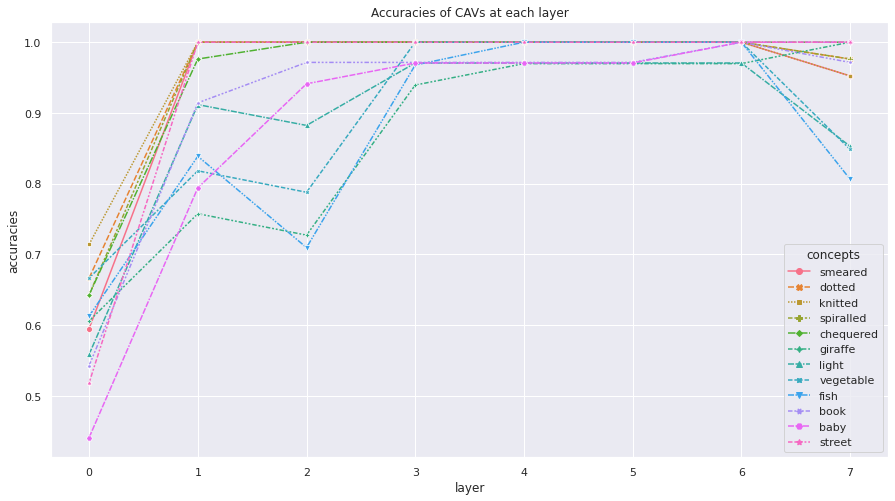

In [127]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(acc, index = image_classes)
df.index.name = 'concepts'
df_2 = df.transpose()
sns.set(rc = {'figure.figsize':(15,8)})
# for i in range(len(image_classes)):
#     ax = sns.lineplot(data=acc[i], markers=True)
ax = sns.lineplot(data=df_2, markers=True)
ax.set_title('Accuracies of CAVs at each layer')
ax.set_ylabel('accuracies')
ax.set_xlabel('layer')

Text(0.5, 0, 'layer')

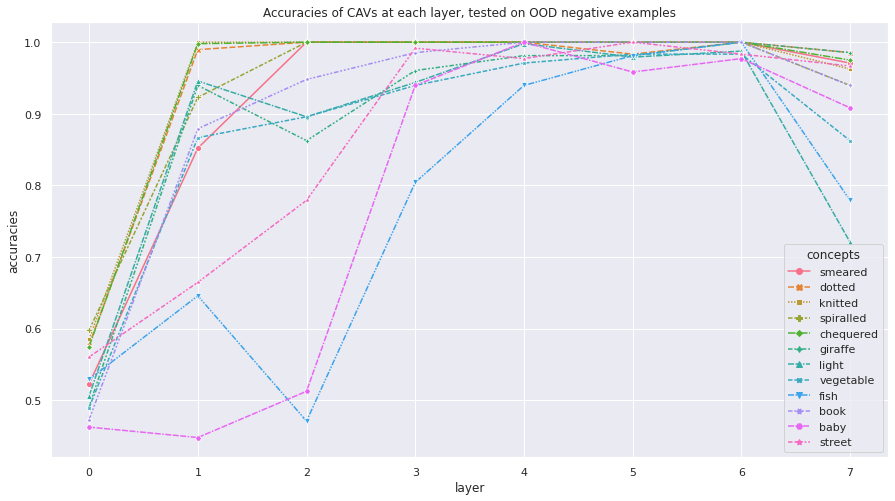

In [129]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(n_acc, index = image_classes)
df.index.name = 'concepts'
df_2 = df.transpose()
sns.set(rc = {'figure.figsize':(15,8)})
# for i in range(len(image_classes)):
#     ax = sns.lineplot(data=acc[i], markers=True)
ax = sns.lineplot(data=df_2, markers=True)
ax.set_title('Accuracies of CAVs at each layer, tested on OOD negative examples')
ax.set_ylabel('accuracies')
ax.set_xlabel('layer')

# Collect features

In [160]:
outputs = model.encode_image(all_img_tensors)


In [161]:
text_inputs = ["zebra"] * len(positive_concept) + ["not zebra"] * len(negative_concept)


In [162]:

text_inputs = [clip.tokenize([text_input]).to(device) for text_input in text_inputs]
target = torch.vstack([model.encode_text(text_input).float() for text_input in text_inputs])

In [163]:
all_layer_gradients = {}
all_layer_activations = {}
for layer, name in zip(layers, layernames):
    layer_gradients = []
    layer_activations = []
    with Hook(layer) as hook:

        # Do a forward and backward pass.
        output = model.encode_image(all_img_tensors)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()
        layer_gradients.append(grad)
        layer_activations.append(act)
    all_layer_gradients[name] = layer_gradients
    all_layer_activations[name] = layer_activations

RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 14.76 GiB total capacity; 9.83 GiB already allocated; 7.75 MiB free; 10.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [54]:
with open("all_layer_gradients.pkl","wb") as f:
    pickle.dump(all_layer_gradients,f)

In [55]:
with open("all_layer_activations.pkl","wb") as f:
    pickle.dump(all_layer_activations,f)

# Process features

In [158]:
training_data =  []
linear_classifier_sizes = []
for key in all_layer_gradients.keys():
    training_data.append(all_layer_gradients[key][0].view(85,-1))
    linear_classifier_sizes.append(all_layer_gradients[key][0].view(85,-1).shape[-1])
    

NameError: name 'all_layer_gradients' is not defined

# Assemble training data for all layers

In [42]:
positive_labels = torch.tensor(positive_concepts.shape[0] * [1])
negative_labels = torch.tensor(negative_concepts.shape[0] * [0])
# training_data = torch.vstack([positive_concepts, negative_concepts])
class_labels = torch.cat([positive_labels, negative_labels])

Assemble validation data for all layers

In [59]:
len_train = int( train.shape[0] * 0.7)

In [66]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [ len_train, train.shape[0]-len_train] )

# Create dataloaders

In [73]:
criterion = torch.nn.BCEWithLogitsLoss()
dataloaders = []
val_dataloaders = []
for train in training_data:
    dataset = TensorDataset(train, class_labels)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [ len_train, train.shape[0] -len_train])
    loader = DataLoader(train_dataset, batch_size=2,
                    pin_memory=False, shuffle=True)
    val_loader = DataLoader(train_dataset, batch_size=2,
                    pin_memory=False, shuffle=True)
    dataloaders.append(loader)
    val_dataloaders.append(val_loader)

# Create classifiers

In [74]:
classifiers = []
for classifier_size in linear_classifier_sizes:    
    classifiers.append(LinearClassifier(classifier_size))


In [87]:
def train_classifier(classifier, dataloader, val_dataloader):
    clf = classifier.cuda()
    early_stopping = EarlyStopping()
    optimizer = torch.optim.SGD(clf.parameters(), lr=0.001)
    for it in range(n_epochs):
        for i, data in enumerate(dataloader,0):
            inputs, labels = data
            inputs = Variable(inputs, requires_grad=True)
            optimizer.zero_grad()
            outputs = clf(inputs.cuda().float())

            loss = criterion(outputs.cuda().float(), labels.cuda().reshape(-1,1).float())
            loss.backward()
            
            
            optimizer.step()
        with torch.no_grad():
            for i, data in enumerate(val_dataloader,0):
                inputs, labels = data
                inputs = Variable(inputs)
                outputs = clf(inputs.cuda().float())

                loss = criterion(outputs.cuda().float(), labels.cuda().reshape(-1,1).float()) 
        
            early_stopping(loss)
        if it % 10 == 0:
            pass
        if early_stopping.early_stop:
            print(loss)
            break

In [88]:
dataloaders

# Training Classifiers Features

In [89]:
n_epochs = 1000
for classifier, dataloader, val_dataloader in zip(classifiers, dataloaders, val_dataloaders):
    print(classifier)
    train_classifier(classifier, dataloader,val_dataloader)
    print("trained a classifier")


LinearClassifier(
  (linear1): Linear(in_features=37632, out_features=1, bias=True)
)
INFO: Early stopping counter 1 of 5
INFO: Early stopping counter 2 of 5
INFO: Early stopping counter 3 of 5
INFO: Early stopping counter 1 of 5
INFO: Early stopping counter 2 of 5
INFO: Early stopping counter 3 of 5
INFO: Early stopping counter 1 of 5
INFO: Early stopping counter 2 of 5
INFO: Early stopping counter 3 of 5
INFO: Early stopping counter 4 of 5
INFO: Early stopping counter 5 of 5
INFO: Early stopping
tensor(0.0622, device='cuda:0')
trained a classifier
LinearClassifier(
  (linear1): Linear(in_features=38400, out_features=1, bias=True)
)
INFO: Early stopping counter 1 of 5
INFO: Early stopping counter 2 of 5
INFO: Early stopping counter 3 of 5
INFO: Early stopping counter 4 of 5
INFO: Early stopping counter 5 of 5
INFO: Early stopping
tensor(0.4219, device='cuda:0')
trained a classifier
LinearClassifier(
  (linear1): Linear(in_features=38400, out_features=1, bias=True)
)
INFO: Early stoppi

In [90]:

with open("cached_classifiers.pkl","wb") as f:
    pickle.dump(classifiers,f)

# Get orthogonal vector

In [91]:
def get_orthogonal_vector(classifier, classifier_size):
    weight, bias = [param for param in classifier.parameters()]
    cav_vector = weight.squeeze().cpu().detach().numpy()
    orthonormal_vector = np.random.randn(classifier_size)  # take a random vector
    orthonormal_vector -= orthonormal_vector.dot(cav_vector) * cav_vector / np.linalg.norm(cav_vector)**2
    orthonormal_vector /= np.linalg.norm(orthonormal_vector) 
    return orthonormal_vector, cav_vector

In [92]:
cavs = [get_orthogonal_vector(classifier, classifier_size) for classifier, classifier_size in zip(classifiers, linear_classifier_sizes)]

# Check orthogonality

In [93]:
[np.dot(orthonormal_vector,cav_vector) for orthonormal_vector, cav_vector in cavs]

[-1.1899124090566926e-10,
 5.035230956143555e-10,
 4.686241134727043e-10,
 2.495054813797526e-11,
 -3.7813513171364166e-11,
 -8.493784451821251e-12,
 5.064932414450274e-11]

In [94]:

for i in range(85):
    print(i)
    print(torch.dot(all_layer_gradients['layer0'][0].view(85,-1)[i], torch.tensor(cavs[0][1]).cuda() ) )

0
tensor(3.1576, device='cuda:0')
1
tensor(0.9237, device='cuda:0')
2
tensor(2.2916, device='cuda:0')
3
tensor(1.3362, device='cuda:0')
4
tensor(0.2581, device='cuda:0')
5
tensor(0.9651, device='cuda:0')
6
tensor(-0.2086, device='cuda:0')
7
tensor(3.5177, device='cuda:0')
8
tensor(1.9983, device='cuda:0')
9
tensor(2.2666, device='cuda:0')
10
tensor(2.7793, device='cuda:0')
11
tensor(1.3769, device='cuda:0')
12
tensor(2.6567, device='cuda:0')
13
tensor(3.3030, device='cuda:0')
14
tensor(-0.0600, device='cuda:0')
15
tensor(1.2082, device='cuda:0')
16
tensor(2.0105, device='cuda:0')
17
tensor(2.5700, device='cuda:0')
18
tensor(3.3431, device='cuda:0')
19
tensor(-0.1400, device='cuda:0')
20
tensor(1.3527, device='cuda:0')
21
tensor(1.8662, device='cuda:0')
22
tensor(-0.1866, device='cuda:0')
23
tensor(2.8525, device='cuda:0')
24
tensor(0.3161, device='cuda:0')
25
tensor(0.6625, device='cuda:0')
26
tensor(4.6133, device='cuda:0')
27
tensor(1.4815, device='cuda:0')
28
tensor(2.0673, device='

In [95]:
for i in range(85):
    print(i)
    print(torch.dot(all_layer_gradients['layer1'][0].view(85,-1)[i], torch.tensor(cavs[1][1]).cuda() ) )

0
tensor(5.6702, device='cuda:0')
1
tensor(3.9695, device='cuda:0')
2
tensor(1.4329, device='cuda:0')
3
tensor(0.9419, device='cuda:0')
4
tensor(0.0106, device='cuda:0')
5
tensor(1.2248, device='cuda:0')
6
tensor(-0.0851, device='cuda:0')
7
tensor(-0.1159, device='cuda:0')
8
tensor(0.7661, device='cuda:0')
9
tensor(0.6483, device='cuda:0')
10
tensor(0.0589, device='cuda:0')
11
tensor(0.8473, device='cuda:0')
12
tensor(0.0159, device='cuda:0')
13
tensor(0.9787, device='cuda:0')
14
tensor(1.2873, device='cuda:0')
15
tensor(0.5961, device='cuda:0')
16
tensor(0.4017, device='cuda:0')
17
tensor(-0.1369, device='cuda:0')
18
tensor(0.7163, device='cuda:0')
19
tensor(0.8413, device='cuda:0')
20
tensor(-0.0288, device='cuda:0')
21
tensor(0.6438, device='cuda:0')
22
tensor(0.8506, device='cuda:0')
23
tensor(0.8276, device='cuda:0')
24
tensor(0.8787, device='cuda:0')
25
tensor(1.0171, device='cuda:0')
26
tensor(1.0181, device='cuda:0')
27
tensor(-0.0558, device='cuda:0')
28
tensor(-0.0678, device

In [96]:
for i in range(85):
    print(i)
    print(torch.dot(all_layer_gradients['layer3'][0].view(85,-1)[i], torch.tensor(cavs[2][1]).cuda() ) )

0
tensor(7.8871, device='cuda:0')
1
tensor(4.2670, device='cuda:0')
2
tensor(1.5204, device='cuda:0')
3
tensor(0.9167, device='cuda:0')
4
tensor(0.0608, device='cuda:0')
5
tensor(-0.0854, device='cuda:0')
6
tensor(0.5544, device='cuda:0')
7
tensor(0.8682, device='cuda:0')
8
tensor(0.0067, device='cuda:0')
9
tensor(0.0300, device='cuda:0')
10
tensor(1.0211, device='cuda:0')
11
tensor(-0.0455, device='cuda:0')
12
tensor(-0.2739, device='cuda:0')
13
tensor(-0.0963, device='cuda:0')
14
tensor(1.0677, device='cuda:0')
15
tensor(0.6390, device='cuda:0')
16
tensor(-0.1569, device='cuda:0')
17
tensor(0.4333, device='cuda:0')
18
tensor(0.6834, device='cuda:0')
19
tensor(0.7324, device='cuda:0')
20
tensor(0.7751, device='cuda:0')
21
tensor(0.6463, device='cuda:0')
22
tensor(0.5030, device='cuda:0')
23
tensor(0.0405, device='cuda:0')
24
tensor(0.7992, device='cuda:0')
25
tensor(0.7743, device='cuda:0')
26
tensor(0.9330, device='cuda:0')
27
tensor(0.0239, device='cuda:0')
28
tensor(0.6674, device=

In [97]:
for i in range(85):
    print(i)
    print(torch.dot(all_layer_gradients['layer5'][0].view(85,-1)[i], torch.tensor(cavs[3][1]).cuda() ) )

0
tensor(5.0756, device='cuda:0')
1
tensor(3.6719, device='cuda:0')
2
tensor(0.8010, device='cuda:0')
3
tensor(0.4374, device='cuda:0')
4
tensor(0.3537, device='cuda:0')
5
tensor(0.5322, device='cuda:0')
6
tensor(0.0891, device='cuda:0')
7
tensor(0.4082, device='cuda:0')
8
tensor(0.0384, device='cuda:0')
9
tensor(0.0883, device='cuda:0')
10
tensor(0.0774, device='cuda:0')
11
tensor(0.0869, device='cuda:0')
12
tensor(0.0322, device='cuda:0')
13
tensor(0.4059, device='cuda:0')
14
tensor(0.4620, device='cuda:0')
15
tensor(0.1910, device='cuda:0')
16
tensor(0.2752, device='cuda:0')
17
tensor(0.2014, device='cuda:0')
18
tensor(0.2736, device='cuda:0')
19
tensor(0.3711, device='cuda:0')
20
tensor(0.2790, device='cuda:0')
21
tensor(0.3665, device='cuda:0')
22
tensor(0.3064, device='cuda:0')
23
tensor(0.4076, device='cuda:0')
24
tensor(0.3593, device='cuda:0')
25
tensor(0.3061, device='cuda:0')
26
tensor(0.4341, device='cuda:0')
27
tensor(0.1547, device='cuda:0')
28
tensor(0.3427, device='cuda

In [98]:
for i in range(85):
    print(i)
    print(torch.dot(all_layer_gradients['layer7'][0].view(85,-1)[i], torch.tensor(cavs[4][1]).cuda() ) )

0
tensor(-1.1681, device='cuda:0')
1
tensor(-0.4685, device='cuda:0')
2
tensor(0.0228, device='cuda:0')
3
tensor(0.1466, device='cuda:0')
4
tensor(0.1614, device='cuda:0')
5
tensor(0.0619, device='cuda:0')
6
tensor(0.1490, device='cuda:0')
7
tensor(0.1648, device='cuda:0')
8
tensor(0.1493, device='cuda:0')
9
tensor(0.1720, device='cuda:0')
10
tensor(0.2074, device='cuda:0')
11
tensor(0.1479, device='cuda:0')
12
tensor(0.3873, device='cuda:0')
13
tensor(0.1705, device='cuda:0')
14
tensor(0.2090, device='cuda:0')
15
tensor(0.2053, device='cuda:0')
16
tensor(0.0004, device='cuda:0')
17
tensor(0.0241, device='cuda:0')
18
tensor(0.1873, device='cuda:0')
19
tensor(0.1511, device='cuda:0')
20
tensor(0.0658, device='cuda:0')
21
tensor(0.2161, device='cuda:0')
22
tensor(0.1166, device='cuda:0')
23
tensor(0.2141, device='cuda:0')
24
tensor(0.0278, device='cuda:0')
25
tensor(0.0408, device='cuda:0')
26
tensor(0.2271, device='cuda:0')
27
tensor(0.1222, device='cuda:0')
28
tensor(0.0928, device='cu

In [99]:
for i in range(85):
    print(i)
    print(torch.dot(all_layer_gradients['layer9'][0].view(85,-1)[i], torch.tensor(cavs[5][1]).cuda() ) )

0
tensor(4.5534, device='cuda:0')
1
tensor(0.9605, device='cuda:0')
2
tensor(0.0407, device='cuda:0')
3
tensor(0.0317, device='cuda:0')
4
tensor(0.0326, device='cuda:0')
5
tensor(0.0408, device='cuda:0')
6
tensor(0.0415, device='cuda:0')
7
tensor(0.0314, device='cuda:0')
8
tensor(0.0179, device='cuda:0')
9
tensor(0.0268, device='cuda:0')
10
tensor(0.0683, device='cuda:0')
11
tensor(0.0242, device='cuda:0')
12
tensor(0.0112, device='cuda:0')
13
tensor(0.0377, device='cuda:0')
14
tensor(0.0097, device='cuda:0')
15
tensor(0.0306, device='cuda:0')
16
tensor(0.0244, device='cuda:0')
17
tensor(0.0053, device='cuda:0')
18
tensor(0.0475, device='cuda:0')
19
tensor(0.0257, device='cuda:0')
20
tensor(0.0352, device='cuda:0')
21
tensor(0.0253, device='cuda:0')
22
tensor(0.0428, device='cuda:0')
23
tensor(0.0569, device='cuda:0')
24
tensor(0.0069, device='cuda:0')
25
tensor(0.0200, device='cuda:0')
26
tensor(0.0146, device='cuda:0')
27
tensor(0.0383, device='cuda:0')
28
tensor(0.0244, device='cuda

In [100]:
for i in range(85):
    print(i)
    print(torch.dot(all_layer_gradients['layer11'][0].view(85,-1)[i], torch.tensor(cavs[6][1]).cuda() ) )

0
tensor(4.5974, device='cuda:0')
1
tensor(5.0867, device='cuda:0')
2
tensor(0., device='cuda:0')
3
tensor(0., device='cuda:0')
4
tensor(0., device='cuda:0')
5
tensor(0., device='cuda:0')
6
tensor(0., device='cuda:0')
7
tensor(0., device='cuda:0')
8
tensor(0., device='cuda:0')
9
tensor(0., device='cuda:0')
10
tensor(0., device='cuda:0')
11
tensor(0., device='cuda:0')
12
tensor(0., device='cuda:0')
13
tensor(0., device='cuda:0')
14
tensor(0., device='cuda:0')
15
tensor(0., device='cuda:0')
16
tensor(0., device='cuda:0')
17
tensor(0., device='cuda:0')
18
tensor(0., device='cuda:0')
19
tensor(0., device='cuda:0')
20
tensor(0., device='cuda:0')
21
tensor(0., device='cuda:0')
22
tensor(0., device='cuda:0')
23
tensor(0., device='cuda:0')
24
tensor(0., device='cuda:0')
25
tensor(0., device='cuda:0')
26
tensor(0., device='cuda:0')
27
tensor(0., device='cuda:0')
28
tensor(0., device='cuda:0')
29
tensor(0., device='cuda:0')
30
tensor(0., device='cuda:0')
31
tensor(0., device='cuda:0')
32
tensor(

You need labels to get gradients, to get a loss to backpropagate with

# Calculate TCAV score

In [167]:
image = preprocess(Image.open('tcav/concepts/striped/striped_0086.jpg')).unsqueeze(0).to(device)
image_features = model.encode_image(image.cuda())

In [182]:
x = Variable(image.cuda(), requires_grad=True)

In [183]:
y = model.encode_image(x)

In [184]:
y.backward(torch.ones(1,1024).cuda())

In [195]:
model.visual.proj

torch.Size([768, 512])